In [0]:
#%pip install tensorflow
#%pip install mlflow

## Statistikos Departamento Užduotis
### RNN Model implementation for covid-19 cases forecast in Lithuania a.k.a. Visualisations using spark

#### 1. Retrieve data and packages

In [0]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot

from pyspark.sql.functions import desc, round
from pyspark import SparkFiles
from pyspark.ml.evaluation import RegressionEvaluator
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
spark.sparkContext.addFile("https://get.data.gov.lt/datasets/gov/lsd/covid19/SvieslenciuStatistika/:format/csv")

In [0]:
df = spark.read.csv("file://"+SparkFiles.get("csv"), header=True, inferSchema= True)
#display(df)

In [0]:
# filtered correlated columns
cols = ['ab_neg_day', 'ab_pos_day','date','dgn_neg_day', 'dgn_pos_day','incidence',
       'cumulative_totals', 'active_de_jure', 'dead_cases','recovered_de_jure']

In [0]:
df = df[cols].groupBy('date').sum()
df = df.orderBy('date', ascending=True)

# let's implement the model for the country forecast. maybe will implement municipality predictions in the future ##'municipality_name','population'

In [0]:
df.show(1)

+----------+---------------+---------------+----------------+----------------+--------------+----------------------+-------------------+---------------+----------------------+
 date|sum(ab_neg_day)|sum(ab_pos_day)|sum(dgn_neg_day)|sum(dgn_pos_day)|sum(incidence)|sum(cumulative_totals)|sum(active_de_jure)|sum(dead_cases)|sum(recovered_de_jure)|
+----------+---------------+---------------+----------------+----------------+--------------+----------------------+-------------------+---------------+----------------------+
2020-03-20| 0| 0| 216| 12| 12| 16| 16| 0| 0|
+----------+---------------+---------------+----------------+----------------+--------------+----------------------+-------------------+---------------+----------------------+
only showing top 1 row

#### 2. Training and Test set preparation

In [0]:
#Drop nulls and date column
df = df.dropna() 
dataset = df.drop('date')
 
#display(dataset)

In [0]:
values = dataset.collect()

In [0]:
scaler = StandardScaler()
scaled = scaler.fit_transform(values)

In [0]:
# Create features and label dataset. NOTE: We're predicting a value 14 days into the future. 

X = scaled[:][:-14] # remove readings from last 14 days
y = scaled[:,-3][14:] # target column excluding first 14 days

In [0]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.20, random_state=42, shuffle = False)

# Create windows with lagged values
timesteps = 14 # how many days to forecast
train_generator = TimeseriesGenerator(trainX, trainY, length=timesteps, sampling_rate=1, batch_size=timesteps)
test_generator = TimeseriesGenerator(testX, testY, length=timesteps, sampling_rate=1, batch_size=timesteps)

In [0]:
##  data info
train_X, train_y = train_generator[0]
test_X, test_y = test_generator[0]

train_samples = train_X.shape[0]*len(train_generator)
test_samples = test_X.shape[0]*len(test_generator)

print("Days of info (n): {}".format(df.count()))
print("Info for 14d periods: {}".format(len(X)))
print("training set size: trainX = {}".format(trainX.shape[0]))
print(" testing set size: testX = {}".format(testX.shape[0]))

print("samples in training feature set: {}".format(train_samples))
print("samples in testing feature set: {}".format(test_samples))

Days of info (n): 565
Info for 14d periods: 551
training set size: trainX = 440
 testing set size: testX = 111
samples in training feature set: 434
samples in testing feature set: 98

#### 3. Modeling RNN

In [0]:
import mlflow
import mlflow.keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [0]:
units = 128 # how many neurons
num_epoch = 100
lr = 0.0001

In [0]:
model = Sequential()
model.add(LSTM(units, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [0]:
# save your work
experiment_log_dir = "/dbfs/kostgrisk/tb"
checkpoint_path = "/dbfs/kostgrisk/keras_checkpoint_weights.ckpt"
 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=experiment_log_dir)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor="loss", mode="min", patience=10)

In [0]:
history = model.fit(train_generator, \
                                epochs=num_epoch, \
                                validation_data=test_generator, \
                                callbacks = [tensorboard_callback, model_checkpoint, early_stopping], \
                                verbose=2, \
                                shuffle=False, \
                                initial_epoch=0)

Epoch 1/100

31/31 - 3s - loss: 0.2637 - mae: 0.4230 - val_loss: 0.3889 - val_mae: 0.6014

Epoch 00001: val_loss improved from inf to 0.38893, saving model to /dbfs/kostgrisk/keras_checkpoint_weights.ckpt

WARNING:absl:Found untraced functions such as lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_fn, lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 5 of 5). These functions will not be directly callable after loading.

INFO:tensorflow:Assets written to: /dbfs/kostgrisk/keras_checkpoint_weights.ckpt/assets

INFO:tensorflow:Assets written to: /dbfs/kostgrisk/keras_checkpoint_weights.ckpt/assets

Epoch 2/100

31/31 - 0s - loss: 0.1693 - mae: 0.2891 - val_loss: 0.0114 - val_mae: 0.0903

Epoch 00002: val_loss improved from 0.38893 to 0.01144, saving model to /dbfs/kostgrisk/keras_checkpoint_weights.ckpt

WARNING:absl:Found untraced functions such as lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_fn, lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 5 of 5). These functions will not be directly callable after loading.

INFO:tensorflow:Assets written to: /dbfs/kostgrisk/keras_checkpoint_weights.ckpt/assets

INFO:tensorflow:Assets written to: /dbfs/kostgrisk/keras_checkpoint_weights.ckpt/assets

Epoch 3/100

31/31 - 0s - loss: 0.2488 - mae: 0.3421 - val_loss: 0.0124 - val_mae: 0.0990

Epoch 00003: val_loss did not improve from 0.01144
Epoch 4/100

31/31 - 0s - loss: 0.0313 - mae: 0.1347 - val_loss: 0.0466 - val_mae: 0.1973

Epoch 00004: val_loss did not improve from 0.01144
Epoch 5/100

31/31 - 0s - loss: 0.0212 - mae: 0.1165 - val_loss: 0.0067 - val_mae: 0.0718

Epoch 00005: val_loss improved from 0.01144 to 0.00667, saving model to /dbfs/kostgrisk/keras_checkpoint_weights.ckpt

WARNING:absl:Found untraced functions such as lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_fn, lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 5 of 5). These functions will not be directly callable after loading.

INFO:tensorflow:Assets written to: /dbfs/kostgrisk/keras_checkpoint_weights.ckpt/assets

INFO:tensorflow:Assets written to: /dbfs/kostgrisk/keras_checkpoint_weights.ckpt/assets

Epoch 6/100

31/31 - 0s - loss: 0.0262 - mae: 0.1284 - val_loss: 0.0076 - val_mae: 0.0739

Epoch 00006: val_loss did not improve from 0.00667
Epoch 7/100

31/31 - 0s - loss: 0.0116 - mae: 0.0848 - val_loss: 0.0052 - val_mae: 0.0560

Epoch 00007: val_loss improved from 0.00667 to 0.00522, saving model to /dbfs/kostgrisk/keras_checkpoint_weights.ckpt

WARNING:absl:Found untraced functions such as lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_fn, lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 5 of 5). These functions will not be directly callable after loading.

INFO:tensorflow:Assets written to: /dbfs/kostgrisk/keras_checkpoint_weights.ckpt/assets

INFO:tensorflow:Assets written to: /dbfs/kostgrisk/keras_checkpoint_weights.ckpt/assets

Epoch 8/100

31/31 - 1s - loss: 0.0139 - mae: 0.0911 - val_loss: 0.0072 - val_mae: 0.0621

Epoch 00008: val_loss did not improve from 0.00522
Epoch 9/100

31/31 - 1s - loss: 0.0124 - mae: 0.0906 - val_loss: 0.0081 - val_mae: 0.0691

Epoch 00009: val_loss did not improve from 0.00522
Epoch 10/100

31/31 - 0s - loss: 0.0118 - mae: 0.0878 - val_loss: 0.0092 - val_mae: 0.0844

Epoch 00010: val_loss did not improve from 0.00522
Epoch 11/100

31/31 - 0s - loss: 0.0110 - mae: 0.0868 - val_loss: 0.0091 - val_mae: 0.0753

Epoch 00011: val_loss did not improve from 0.00522
Epoch 12/100

31/31 - 0s - loss: 0.0140 - mae: 0.0953 - val_loss: 0.0077 - val_mae: 0.0752

Epoch 00012: val_loss did not improve from 0.00522
Epoch 13/100

31/31 - 0s - loss: 0.0101 - mae: 0.0793 - val_loss: 0.0101 - val_mae: 0.0910

Epoch 00013: val_loss did not improve from 0.00522
Epoch 14/100

31/31 - 0s - loss: 0.0122 - mae: 0.0862 - val_loss: 0.0099 - val_mae: 0.0906

Epoch 00014: val_loss did not improve from 0.00522
Epoch 15/100

31/31 - 1s - loss: 0.0109 - mae: 0.0808 - val_loss: 0.0144 - val_mae: 0.1117

Epoch 00015: val_loss did not improve from 0.00522
Epoch 16/100

31/31 - 1s - loss: 0.0188 - mae: 0.1074 - val_loss: 0.0054 - val_mae: 0.0589

Epoch 00016: val_loss did not improve from 0.00522
Epoch 17/100

31/31 - 1s - loss: 0.0163 - mae: 0.1026 - val_loss: 0.0233 - val_mae: 0.1401

Epoch 00017: val_loss did not improve from 0.00522
Epoch 18/100

31/31 - 0s - loss: 0.0171 - mae: 0.1032 - val_loss: 0.0102 - val_mae: 0.0766

Epoch 00018: val_loss did not improve from 0.00522
Epoch 19/100

31/31 - 0s - loss: 0.0244 - mae: 0.1353 - val_loss: 0.0066 - val_mae: 0.0637

Epoch 00019: val_loss did not improve from 0.00522
Epoch 20/100

31/31 - 0s - loss: 0.0105 - mae: 0.0806 - val_loss: 0.0087 - val_mae: 0.0783

Epoch 00020: val_loss did not improve from 0.00522
Epoch 21/100

31/31 - 0s - loss: 0.0210 - mae: 0.1197 - val_loss: 0.0080 - val_mae: 0.0701

Epoch 00021: val_loss did not improve from 0.00522
Epoch 22/100

31/31 - 1s - loss: 0.0129 - mae: 0.0900 - val_loss: 0.0149 - val_mae: 0.1139

Epoch 00022: val_loss did not improve from 0.00522
Epoch 23/100

31/31 - 1s - loss: 0.0203 - mae: 0.1114 - val_loss: 0.0072 - val_mae: 0.0708

Epoch 00023: val_loss did not improve from 0.00522

In [0]:
#tf.config.list_physical_devices('CPU') #if you are struggling to run keras, you have to have the correct tf set up with cuda

#### 4. Model Evaluation

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0a74e22a-a9ce-4470-8dda-2af1a0eb704d/lib/python3.8/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
 warnings.warn('`Model.evaluate_generator` is deprecated and '

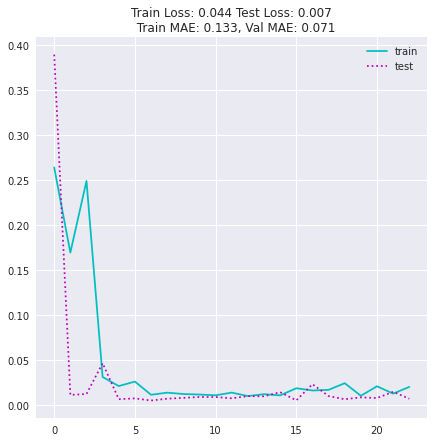

In [0]:
# Calculate the train loss and train metric, in this case mean absolute error
train_loss = np.mean(history.history['loss'])
train_mae = np.mean(history.history['mae'])
score = model.evaluate_generator(test_generator, verbose=0)  

title = 'Train Loss: {0:.3f} Test Loss: {1:.3f}\n  Train MAE: {2:.3f}, Val MAE: {3:.3f}'.format(train_loss, score[0], train_mae, score[1])

# Plot loss function
fig = pyplot.figure()
pyplot.style.use('seaborn')

pyplot.plot(history.history['loss'], 'c-', label='train')
pyplot.plot(history.history['val_loss'], 'm:', label='test')
pyplot.title(title)
pyplot.legend()
pyplot.grid(True)
fig.set_size_inches(w=7,h=7)
#pyplot.close()

In [0]:
predictions = model.predict(test_X)

ids = test_y
prognoze_df = pd.DataFrame(ids, columns=['true'])
prognoze_df['pred'] = predictions
df_predictions = spark.createDataFrame(prognoze_df)

rmse_evaluator = RegressionEvaluator(labelCol="true", predictionCol="pred", metricName="rmse")
mse_evaluator = RegressionEvaluator(labelCol="true", predictionCol="pred", metricName="mse")


validation_rmse = rmse_evaluator.evaluate(df_predictions)
validation_mse = mse_evaluator.evaluate(df_predictions)

print("RMSE: %f, MSE: %f" % (validation_rmse, validation_mse))

RMSE: 0.029660, MSE: 0.000880

#### 5. Results

In [0]:
display(df_predictions)

true,pred
0.6446076896054518,0.63715196
0.6387828325306885,0.63839626
0.6390716684186932,0.64228773
0.6394086436213655,0.64900005
0.635814241459528,0.6438713
0.6364240061119826,0.6420202
0.6323482108034705,0.6508559
0.6305189168461067,0.6577221
0.6280959046745109,0.6689476
0.6283847405625157,0.67180455


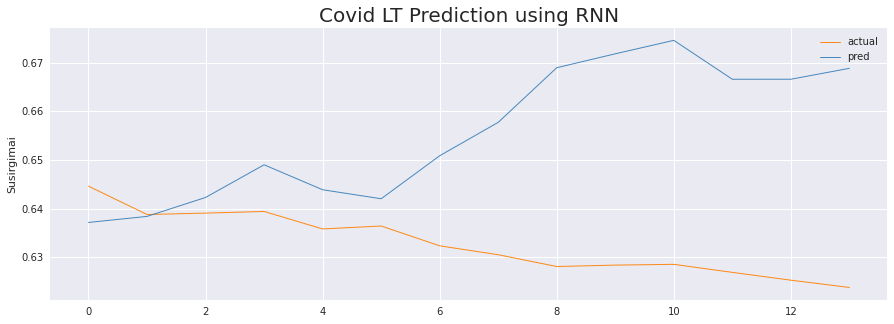

In [0]:
fig = pyplot.figure()

palette = pyplot.get_cmap('Set1')

pyplot.plot(prognoze_df.true, marker='', color=palette(4), linewidth=1, alpha=0.9, label='actual')
pyplot.plot(prognoze_df.pred, marker='', color=palette(1), linewidth=1, alpha=0.9, label='pred')
pyplot.title('Covid LT Prediction using RNN', loc='center', fontsize=20)
pyplot.ylabel('Susirgimai')
pyplot.legend()
fig.set_size_inches(w=15,h=5)